<a href="https://colab.research.google.com/github/dennis-sell/pytorch-fun/blob/master/AdversarialML_Scale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adversarial Machine Learning at Scale
Based on the paper by Kurakin, Goodfellow, and Bengio and published as a conference paper at ICLR 2017.
It explores several attacks on blackbox Classification neural nets, as well as defense methods which involve training against these attacks during model creation - hence the phrase adversarial training. 

Key concepts include transferability of attacks across models, the topic of label leaking, and the comparison of susceptibility to adversarial attacks with overfitting. Given this last point they compare their defense methods to regularization, which seems apt given the relationship between adversarial training, model accuracy, and model capacity. 

Additionally, the results of the paper indicate that a blackbox machine learning model can protect itself from any reasonable attack by using adversarial training. However, this does not come for free and may slightly hurt the model's performance on the intended dataset.

In [0]:
from __future__ import print_function
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as tv_datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
drive_dir = 'drive/My Drive/Colab Notebooks/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def imshow(images, title=None):
    """Imshow for Tensor."""
    images_detached = images.detach()
    out = torchvision.utils.make_grid(images_detached)
    inp = out.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [0]:
def analyze_perturbed_images(p_images, label, nn_model):
    raw_outputs = nn_model(p_images)
    _, predicted = torch.max(raw_outputs.data, 1)
    num_correct = (predicted == labels).sum().item()
    total = labels.size(0)
    print('Accuracy: %d / %d' % (num_correct, total))
    imshow(p_images)

In [0]:
def fgsm_attack(images, labels, model, epsilon=0.0001, criterion=None):
    if criterion == None:
        criterion = nn.CrossEntropyLoss()
    
    # Necessary for attack
    images = images.clone().detach().requires_grad_(True)

    # get gradients
    raw_outputs = model(images)
    model.zero_grad()
    loss = criterion(raw_outputs, labels)
    loss.backward()
    data_grad = images.grad.data
    
    sign_data_grad = data_grad.sign()
    perturbed_image = images + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    return perturbed_image

In [0]:
def one_step_least_likely_attack(images, model, epsilon=0.0001, criterion=None):
    if criterion == None:
        criterion = nn.CrossEntropyLoss()
    
    # Necessary for attack
    images.requires_grad = True
    
    # get gradients
    raw_outputs = model(images)
    _, least_likely_predictions = torch.min(raw_outputs, 1)
    
    model.zero_grad()
    loss = criterion(raw_outputs, least_likely_predictions)
    loss.backward()
    data_grad = images.grad.data
    
    sign_data_grad = data_grad.sign()
    perturbed_image = images + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    return perturbed_image

In [0]:
def iterative_fgsm(images, labels, model, num_steps, epsilon=0.01, criterion=None):
    perturbed_images = images
    for i in range(num_steps):
        perturbed_images = fgsm_attack(perturbed_images, labels, model, epsilon, criterion)
    return perturbed_images

In [0]:
def iterative_ll(images, model, num_steps, epsilon=0.01, criterion=None):
    perturbed_images = images
    for i in range(num_steps):
        perturbed_images = one_step_least_likely_attack(
            perturbed_images,
            model,
            epsilon,
            criterion,
        )
    return perturbed_images

# Choosing Models
The paper claims that single-iteration attacks are quite transferable across models, regardless of weights or even architectures. Neverthless let's start off simple with two relatively similar models. The more advanced model has a few more layers and is trained using Batch Normalization, but it is still fundamenetally the same model. 

This should be a good starting place for us. We can build attacks from the simpler VGG model and then attack the more complicated one. 

In [0]:
#vgg16_bn = models.vgg16_bn(pretrained=True)
#vgg13 = models.vgg16(pretrained=True)

It can be difficult to get the imagenet dataset, but I decided to put in the work to get it. The paper was written w/ ImageNet in mind, and that is a much more interesting data set (256x256x3) than say MNIST (28x28x1) or CIFAR (32x32x3).

You can use this: https://github.com/tzutalin/ImageNet_Utils
The imagenet site will only directly give you the images if you are a researcher, but you can always get the URLS of where they are hosted and then download them one by one.

## Backup Plan: CIFAR

Can also use CIFAR dataset since that is easier. Follow the [tutorial for an example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py)

Not a huge fan of the fact that there is no matching model-dataset pair for vision problems in pytorch.

In [0]:
# Copy model def from other class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
# Get pre-trained model (See cifar script for how it is generated)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cifar10_cnn = Net()

cifar10_cnn.load_state_dict(torch.load(drive_dir + 'data/cifar10.pt'))

# Get data from pytorch
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10,
                                         shuffle=False, num_workers=2)

dataiter = iter(testloader)

Files already downloaded and verified


In [12]:
# Test that the model is ok.
images, labels = dataiter.next()
raw_outputs = cifar10_cnn(images)
_, predicted = torch.max(raw_outputs.data, 1)
num_correct = (predicted == labels).sum().item()
total = labels.size(0)
print('Accuracy: %d / %d' % (num_correct, total))

Accuracy: 7 / 10


# Adversarial Example Generation
Generate them and first make sure that the images look the same as the original image. Or at least close, if you set a large pertubation of the image in the attack.

Then see that the model's accuracy has went down by quite a bit.

Accuracy: 3 / 10


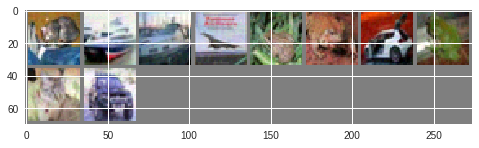

In [13]:
perturbed_images = fgsm_attack(images, labels, cifar10_cnn, epsilon=0.05)
analyze_perturbed_images(perturbed_images, labels, cifar10_cnn)

Accuracy: 7 / 10


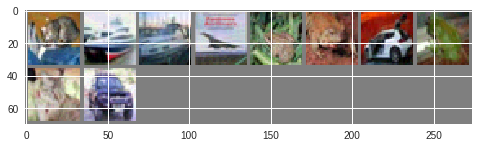

In [14]:
perturbed_images_ll = one_step_least_likely_attack(images, cifar10_cnn, epsilon=0.05)
analyze_perturbed_images(perturbed_images_ll, labels, cifar10_cnn)

Accuracy: 4 / 10


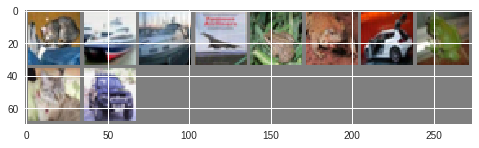

In [15]:
perturbed_images_iter_fgsm = iterative_fgsm(images, labels, cifar10_cnn, num_steps=5, epsilon=0.002)
analyze_perturbed_images(perturbed_images_iter_fgsm, labels, cifar10_cnn)

Accuracy: 7 / 10


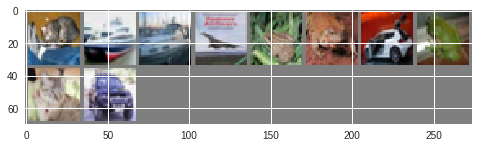

In [16]:
perturbed_images_iter_fgsm = iterative_ll(images, cifar10_cnn, num_steps=1, epsilon=0.01)
analyze_perturbed_images(perturbed_images_iter_fgsm, labels, cifar10_cnn)